In [1]:
import os
import re
import pickle
from collections import OrderedDict, Counter
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from myFunctions import *

#### Set loadFromPickle to True if using the pickled stats

In [2]:
# Defines
loadFromPickle = True

pathToPickle = './pickles/stats.pkl'
pathToLyrics = './lyrics/'
tokenPattern = "\\b[a-zA-Z]+\\b"
regex = re.compile(tokenPattern)
stopWords = set(stopwords.words('english'))

In [3]:
if loadFromPickle:
    stats = pickle.load(open(pathToPickle, "rb"))
    corpus, artists, numSongs, numWords, titleUnigrams, titleBigrams, unigrams, bigrams, trigrams = stats

else:
    corpus = []
    artists = OrderedDict()
    numSongs = numWords = 0
    titleUnigrams, titleBigrams, unigrams, bigrams, trigrams = Counter(), Counter(), Counter(), Counter(), Counter()
    
    # loop through artist subfolders in lyrics folder
    for subdir, dirs, files in os.walk(pathToLyrics):
        if subdir == pathToLyrics:
            continue

        artist = subdir[subdir.rindex('/') + 1:].title()
        artists[artist] = len(corpus)  # index in corpus array to retrieve artist data
        artistDoc = ""

        # loop through artist's songs
        for file in files:
            try:
                fh = open(subdir + '/' + file, "r")
                lyrics = fh.read()
                fh.close()
                numSongs += 1
            except:
                continue  # skip if error opening file

            # keep counters of words in song title
            idx = lyrics.index('\n')  # first line is song title
            words = tokenizeSentence(lyrics[:idx], regex)
            titleUnigrams.update(words)
            titleBigrams.update(ngrams(words, 2))

            for sentence in lyrics[idx+1:].splitlines():
                words = tokenizeSentence(sentence, regex)
                artistDoc += ' '.join(words) + ' '

                # update global counts of n=1 to n=3 gram frequencies
                numWords += len(words)
                unigrams.update(words)
                bigrams.update(ngrams(words, 2))
                trigrams.update(ngrams(words, 3))
        corpus.append(artistDoc)

    stats = (corpus, artists, numSongs, numWords, titleUnigrams, titleBigrams, unigrams, bigrams, trigrams)
    pickle.dump(stats, open(pathToPickle, "wb"))

In [4]:
# Create vectorizer objects for analysis

# pure word counts
cv = CountVectorizer(token_pattern=tokenPattern)
counts = cv.fit_transform(corpus).toarray()

# normalized word counts (since we collect more songs for some artists)
tv1 = TfidfVectorizer(token_pattern=tokenPattern, norm='l2', use_idf=False)
tf = tv1.fit_transform(corpus).toarray()

# normalized word counts with idf weighting
tv2 = TfidfVectorizer(token_pattern=tokenPattern, norm='l2', use_idf=True)
tfidf = tv2.fit_transform(corpus).toarray()

allWords = cv.get_feature_names()
wordIdxs = {allWords[i]: i for i in range(len(allWords))}  # for quick lookup at word level

## Lyric Collection Overview

In [5]:
allArtists = list(artists.keys())
print("Number of artists: {}".format(len(allArtists)))
print("Some of the artists are:")
print(*allArtists[:8], sep=', ')

Number of artists: 150
Some of the artists are:
Justin Timberlake, Ellie Goulding, Harry Styles, Mike Posner, Leona Lewis, Jay Sean, Lizzo, Justin Bieber


In [6]:
print("Number of songs: {}".format(numSongs))
print("Number of words: {}".format(numWords))
print("Average words per song: {:.1f}".format(numWords / numSongs))
print("Number of unique words: {}".format(len(unigrams)))

Number of songs: 2778
Number of words: 968760
Average words per song: 348.7
Number of unique words: 16051


## Song Title Analysis

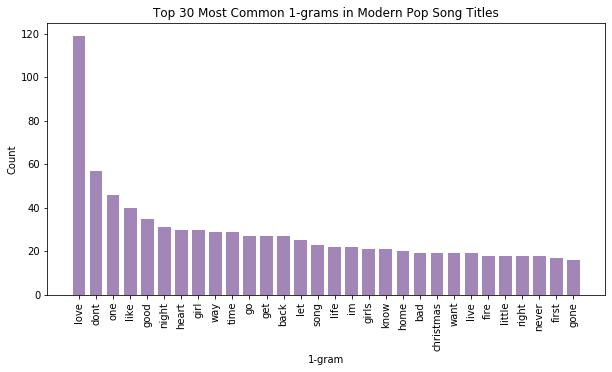

In [7]:
filtered = [x for x in titleUnigrams.most_common() if x[0] not in stopWords][:30]
plotBarGraph(filtered, 1, True, "")

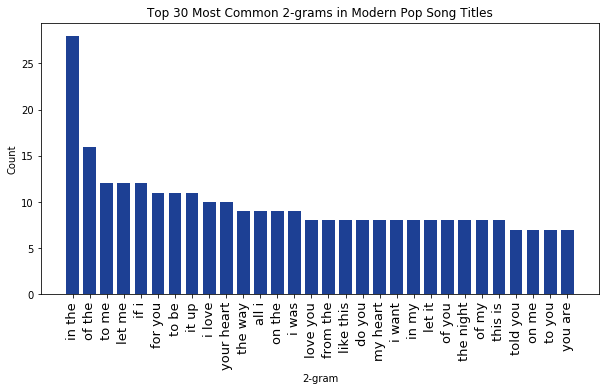

In [8]:
plotBarGraph(titleBigrams.most_common(30), 2, True, "")

## Lyric Analysis

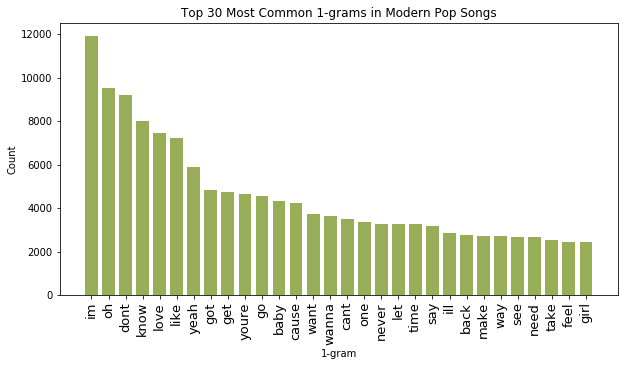

In [9]:
filtered = [x for x in unigrams.most_common() if x[0] not in stopWords][:30]
plotBarGraph(filtered, 1, False, "")

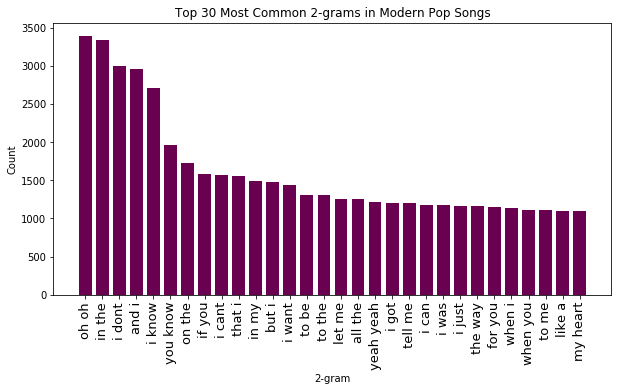

In [10]:
plotBarGraph(bigrams.most_common(30), 2, False, "")

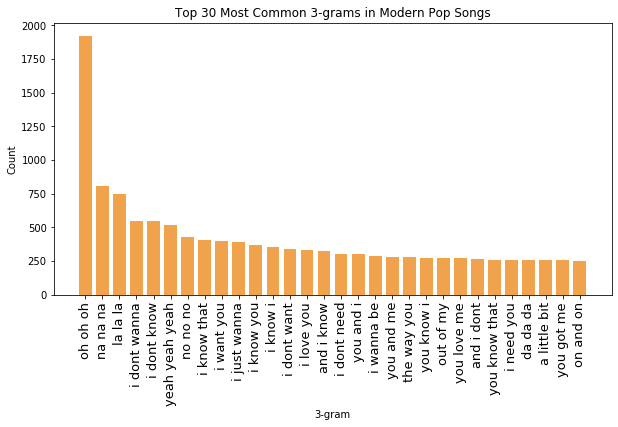

In [11]:
plotBarGraph(trigrams.most_common(30), 3, False, "")

## Artist Lyric Breakdown

#### Choose an artist

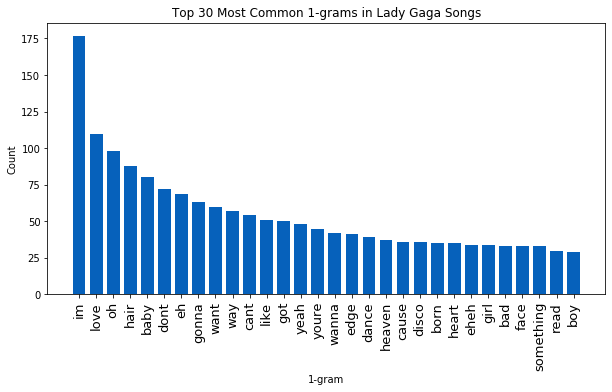

In [12]:
artist = 'Lady Gaga'
displayArtistWords(artist, artists, allWords, counts)

## Word Popularity

#### Choose a word to see which artists have used it

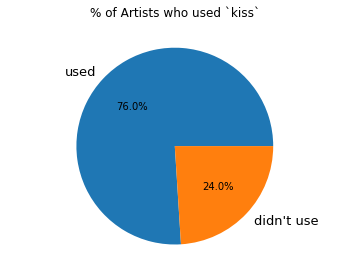


And these artists used kiss the most

+------------------+--------------+
|      Artist      | Uses of kiss |
+------------------+--------------+
|     Dua Lipa     |      77      |
|   Lana Del Rey   |      31      |
|    Bebe Rexha    |      29      |
|       P!Nk       |      21      |
| Carly Rae Jepsen |      21      |
+------------------+--------------+


In [13]:
word = 'kiss'
getWordStats(word, wordIdxs, counts, allArtists)

## Artist Lyric Comparison

#### Compare two artists, or choose just artist1 (artist2 = None)

In [14]:
artist1 = 'Miley Cyrus'
artist2 = None
compareArtists(artist1, artist2, artists, tf, tfidf, allWords)


Artists with most similar vocabulary to Miley Cyrus

+-------------+--------------------+----------------------+-------------------------+
|    Artist   | Jaccard Similarity | TF Cosine Similarity | TFIDF Cosine Similarity |
+-------------+--------------------+----------------------+-------------------------+
|  Ed Sheeran |       0.278        |        0.897         |           0.82          |
|  Jason Mraz |       0.282        |        0.893         |          0.817          |
| John Legend |       0.242        |         0.9          |          0.814          |
|     Fun.    |        0.3         |         0.88         |          0.812          |
| Niall Horan |        0.34        |        0.884         |          0.809          |
+-------------+--------------------+----------------------+-------------------------+
